In [3]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization



In [4]:
LANDMARK_NAMES = {
    1: "S",    # Sella
    2: "Na",   # Nasion
    3: "Or",   # Orbitale
    4: "Po",   # Porion
    5: "A", # A point
    6: "B",    # B point
    7: "Pog",  # Pogonion
    8: "Me",   # Menton
    9: "Gn", # Gn point
    10: "Go",  # Gonion
    11: "L1", # L1 point
    12: "U1", # U1 point
    13: "lower apex",  # lower apex 
    14: "molar",  # molar point
    15: "upper apex",  # upper apex
    16: "premolar", # premolar point
    17: "PNS", # Posterior Nasal Spine
    18: "ANS",   # ANS point
    19: "Ar"   # Articulare
}

(256, 256, 1)
(256, 256, 19)


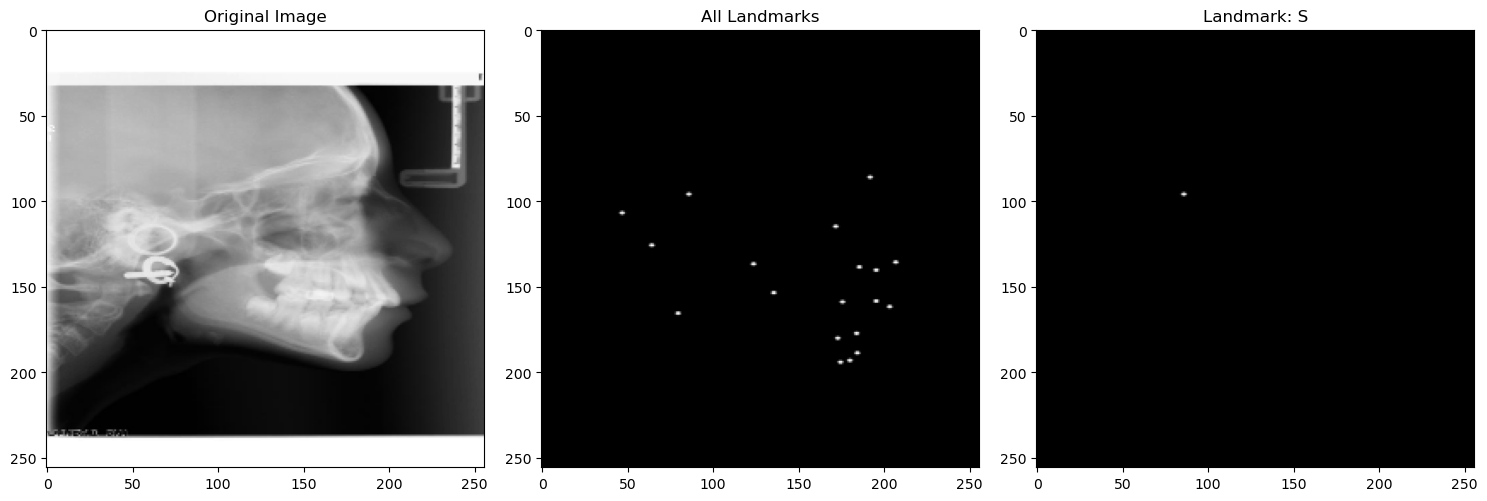

<Figure size 1500x1000 with 0 Axes>

In [5]:

train_inputImg = []
#/kaggle/input/cephalometric-landmarks
train_inputImg.append(pd.read_csv('new1200/train_senior.csv', 
                                 delimiter=',',
                                 dtype={col: float for col in range(1, 38)}))
train_inputImg.append(pd.read_csv('new1200/test1_senior.csv', 
                                 delimiter=',',
                                 dtype={col: float for col in range(1, 38)}))

w = 20
train_images = []
masks = []
train_masks = []

for csv_file in train_inputImg:
    for row in csv_file.values:
        img_landmarks = list(row)
        image = cv2.imread('new1200/ceph400/ceph400/' + str(img_landmarks[0]), 0) / 255
        Mask_Image = np.zeros((image.shape[0], image.shape[1], len(LANDMARK_NAMES)), dtype=np.uint8)
        
    
        for i, (landmark_idx, landmark_name) in enumerate(LANDMARK_NAMES.items()):
            x_idx = 2*landmark_idx - 1
            y_idx = 2*landmark_idx
            x = int(img_landmarks[x_idx])
            y = int(img_landmarks[y_idx])
            mask_layer = Mask_Image[:, :, i].astype(np.uint8)
            cv2.circle(mask_layer, (x, y), radius=4, color=255, thickness=-1)
            Mask_Image[:, :, i] = mask_layer
            Mask_Image[:, :, i] = cv2.GaussianBlur(Mask_Image[:, :, i].astype(np.float32), (5, 5), 0)
        
        masks.append(Mask_Image)
        new_image = cv2.resize(image, (256, 256))
        new_image = new_image.reshape((new_image.shape[0], new_image.shape[1], 1))
        train_images.append(new_image)
        
        resize_mask = cv2.resize(Mask_Image, (256, 256))
        train_masks.append(resize_mask)

size = new_image.shape
print(size)
print(train_masks[0].shape)

# Create a figure with multiple subplots
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(131)
plt.imshow(train_images[0], cmap='gray')
plt.title('Original Image')

# Composite mask (sum of all landmark channels)
plt.subplot(132)
composite_mask = np.sum(train_masks[0], axis=2)
plt.imshow(composite_mask, cmap='gray')
plt.title('All Landmarks')

# Example of a single landmark channel (e.g., Sella point)
plt.subplot(133)
plt.imshow(train_masks[0][:,:,0], cmap='gray')  # Show first landmark channel
plt.title(f'Landmark: {list(LANDMARK_NAMES.values())[0]}')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
plt.tight_layout()
plt.show()

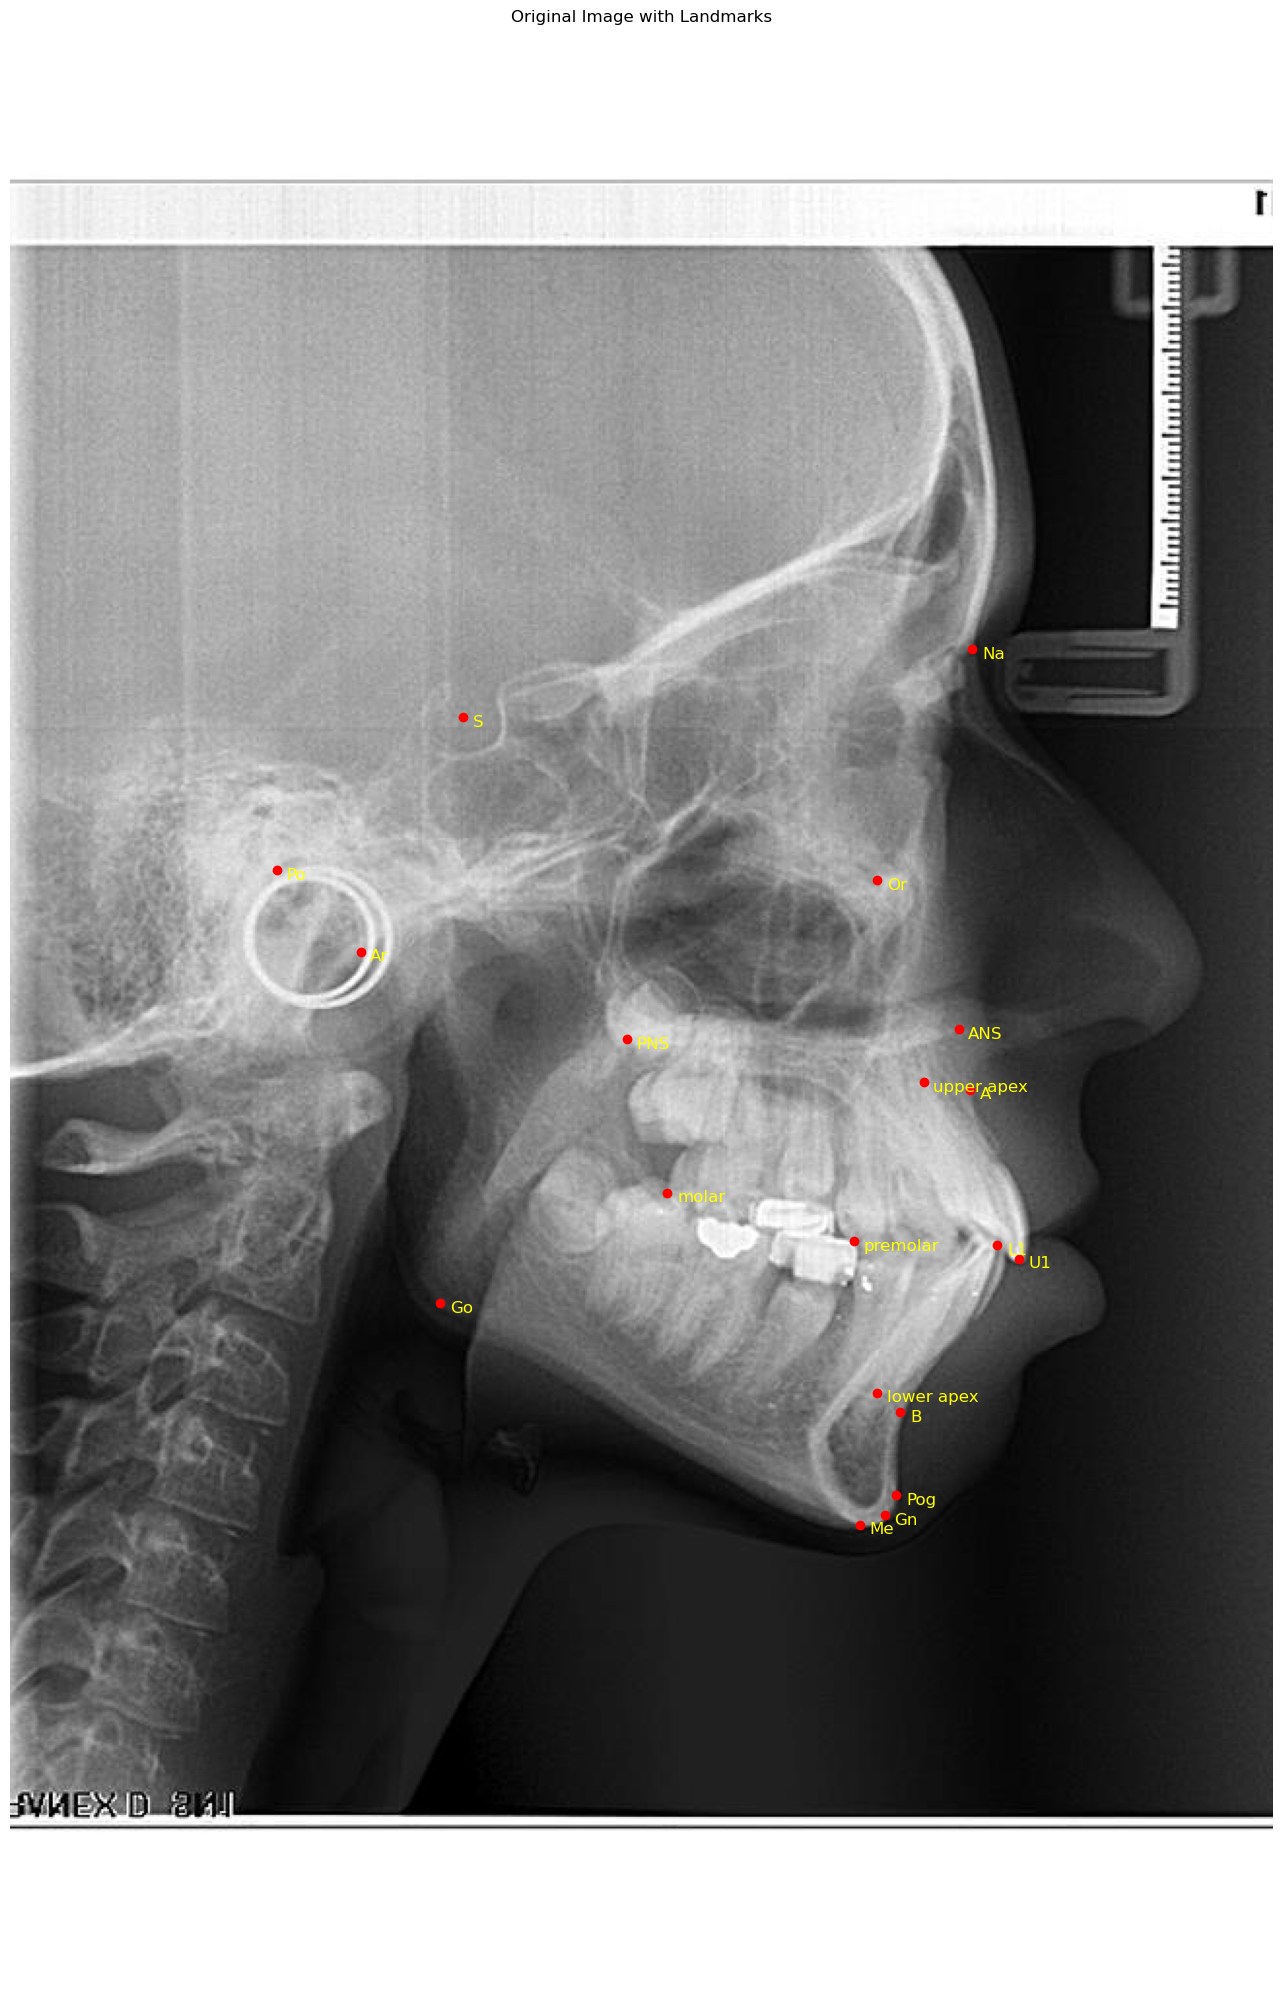

In [6]:
import random

# Randomly select a CSV file
random_csv_file = random.choice(train_inputImg)

# Randomly select a row of data
random_row = random.choice(random_csv_file.values)

img_landmarks = list(random_row)

# Read the corresponding image
image = cv2.imread('new1200/ceph400/ceph400/' + str(img_landmarks[0]), 0) / 255

# Display the image and landmarks
plt.figure(figsize=(20, 20))

# Display the original image
plt.imshow(image, cmap='gray')
plt.title('Original Image with Landmarks')

# Display the landmarks
for i, (landmark_idx, landmark_name) in enumerate(LANDMARK_NAMES.items()):
    if landmark_name != "null":
        x_idx = 2 * landmark_idx - 1
        y_idx = 2 * landmark_idx
        x = int(img_landmarks[x_idx])
        y = int(img_landmarks[y_idx])
        
        # Plot the landmark point
        plt.plot(x, y, 'ro')  # Red point
        plt.text(x + 5, y + 5, landmark_name, color='yellow', fontsize=12)  # Landmark name

plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()


In [7]:
def process_landmarks(row, image_shape, w=20):
    img_landmarks = list(row)
    Mask_Image = np.zeros((image_shape[0], image_shape[1], len(LANDMARK_NAMES)))
    landmark_positions = {}
    
    for i, (landmark_idx, landmark_name) in enumerate(LANDMARK_NAMES.items(), 1):
        x_idx = 2*landmark_idx - 1
        y_idx = 2*landmark_idx
        x = int(img_landmarks[x_idx])
        y = int(img_landmarks[y_idx])
        Mask_Image[y-w:y+w, x-w:x+w, i-1] = 1
        landmark_positions[landmark_name] = (x, y)
    
    return Mask_Image, landmark_positions

(256, 256, 1)
(256, 256, 19)
(256, 256, 1)


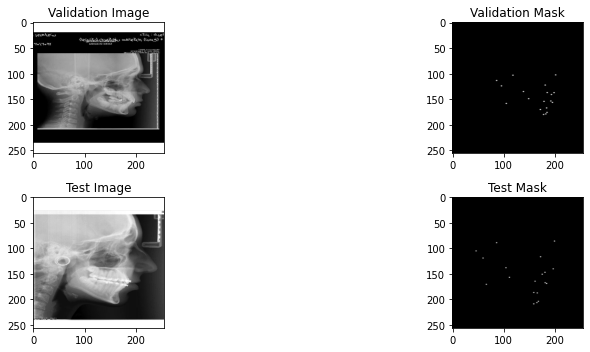

In [8]:
plt.rcParams["figure.figsize"] = (5,5)
val_test_inputImg = pd.read_csv('new1200/test2_senior.csv', 
                               delimiter=',',
                               dtype={col: float for col in range(1, 38)})
val_images = []
val_masks_orig = []
val_masks = []
test_images = []
test_masks_orig = []
test_masks = []
count = 1

for row in val_test_inputImg.values:
    img_landmarks = list(row)
    image = cv2.imread('new1200/ceph400/ceph400/' + str(img_landmarks[0]), 0) / 255
    Mask_Image = np.zeros((image.shape[0], image.shape[1], len(LANDMARK_NAMES)), dtype=np.uint8)
    for i, (landmark_idx, landmark_name) in enumerate(LANDMARK_NAMES.items()):
        x_idx = 2*landmark_idx - 1
        y_idx = 2*landmark_idx
        x = int(img_landmarks[x_idx])
        y = int(img_landmarks[y_idx])
        mask_layer = Mask_Image[:, :, i].astype(np.uint8)
        cv2.circle(mask_layer, (x, y), radius=4, color=255, thickness=-1)
        Mask_Image[:, :, i] = mask_layer
        Mask_Image[:, :, i] = cv2.GaussianBlur(Mask_Image[:, :, i].astype(np.float32), (5, 5), 0)


    new_image = cv2.resize(image,(256,256))
    new_image = new_image.reshape((new_image.shape[0],new_image.shape[1],1))
    resize_mask = cv2.resize(Mask_Image,(256,256))
    
    if count <= 50:
        val_images.append(new_image)
        val_masks_orig.append(Mask_Image)
        val_masks.append(resize_mask)
    else:
        test_images.append(new_image)
        test_masks_orig.append(Mask_Image)
        test_masks.append(resize_mask)
    
    count += 1

size = new_image.shape
print(size)
print(val_masks[0].shape)
print(val_images[0].shape)

# Modified visualization to handle multi-channel masks
plt.figure(figsize=(15, 5))

# Validation data
plt.subplot(221)
plt.imshow(val_images[0], cmap='gray')
plt.title("Validation Image")

plt.subplot(222)
composite_mask_val = np.sum(val_masks[0], axis=2)  # Combine all channels
plt.imshow(composite_mask_val, cmap='gray')
plt.title("Validation Mask")

# Test data
plt.subplot(223)
plt.imshow(test_images[0], cmap='gray')
plt.title("Test Image")

plt.subplot(224)
composite_mask_test = np.sum(test_masks[0], axis=2)  # Combine all channels
plt.imshow(composite_mask_test, cmap='gray')
plt.title("Test Mask")

plt.tight_layout()
plt.show()

In [9]:
train_images = [cv2.resize(img, (256, 256)).reshape(256, 256, 1) for img in train_images]
val_images = [cv2.resize(img, (256, 256)).reshape(256, 256, 1) for img in val_images]
train_masks = [cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
               .reshape(256, 256, len(LANDMARK_NAMES)) for mask in train_masks]

val_masks = [cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
             .reshape(256, 256, len(LANDMARK_NAMES)) for mask in val_masks]
train_images = [img for img in train_images if img.shape == (256, 256, 1)]
train_masks = [mask for mask in train_masks if mask.shape == (256, 256, len(LANDMARK_NAMES))]

val_images = [img for img in val_images if img.shape == (256, 256, 1)]
val_masks = [mask for mask in val_masks if mask.shape == (256, 256, len(LANDMARK_NAMES))]


In [10]:
train_images_stacked = np.stack(train_images, axis=0)
train_masks_stacked = np.stack(train_masks, axis=0)

val_images_stacked = np.stack(val_images, axis=0)
val_masks_stacked = np.stack(val_masks, axis=0)
val_data = (val_images_stacked, val_masks_stacked)

In [11]:
print(train_images_stacked.shape)
print(train_masks_stacked.shape)

(1012, 256, 256, 1)
(1012, 256, 256, 19)


In [12]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    
    conv = BatchNormalization()(conv)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [13]:
def upsampling_block(expansive_input, contractive_input, n_filters=32, output=False):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)
    conv = BatchNormalization()(conv)
        
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    
    if not output:
        conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
        conv = BatchNormalization()(conv)
    
    return conv

In [14]:
def unet_model(input_size, n_filters=64):
    
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8, False)
    
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4, False)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2, False)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters, True)

    #conv9 = Conv2D(n_filters,
    #             3,
    #             activation='relu',
    #             padding='same',
    #            kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(len(LANDMARK_NAMES), kernel_size=1, activation='sigmoid', padding='same')(ublock9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [15]:
def extract_landmark_positions(prediction, threshold=0.5):
    landmark_positions = {}
    for i, (_, landmark_name) in enumerate(LANDMARK_NAMES.items()):
        if landmark_name != "null":
            heatmap = prediction[:,:,i]
            y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
            if heatmap[y, x] > threshold:
                landmark_positions[landmark_name] = (x, y)
    return landmark_positions

def predict_landmarks(model, image):
    resized_image = cv2.resize(image, (256, 256))
    input_image = resized_image.reshape((1, 256, 256, 1))
    prediction = model.predict(input_image)[0]
    landmarks = extract_landmark_positions(prediction)
    scale_x = image.shape[1] / 256
    scale_y = image.shape[0] / 256
    scaled_landmarks = {
        name: (int(x * scale_x), int(y * scale_y))
        for name, (x, y) in landmarks.items()
    }
    return scaled_landmarks

In [16]:
epsilon = 1e-7
import tensorflow.keras.backend as K

def dice_coeff(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(K.cast(y_true, dtype='float32'))
    y_pred_f = K.flatten(K.cast(y_pred, dtype='float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)


In [17]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
checkpoint_filepath = 'checkpoint_20channels'
checkpoint_20channels = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_dice_coeff',
    save_best_only=True)

In [18]:
print(size)
unet = unet_model(size)

(256, 256, 1)


In [19]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=dice_loss,
            metrics=[dice_coeff])

In [20]:
model_history = unet.fit(train_images_stacked, 
                        train_masks_stacked, 
                        batch_size=16,  # Reduced from 32
                        epochs=400,
                        validation_data=val_data,
                        callbacks=[reduce_lr, checkpoint_20channels])

Epoch 1/400
64/64 [==============================] - 50s 541ms/step - loss: 0.9190 - dice_coeff: 0.0813 - val_loss: 0.9557 - val_dice_coeff: 0.0436
Epoch 2/400
64/64 [==============================] - 31s 481ms/step - loss: 0.8437 - dice_coeff: 0.1575 - val_loss: 0.9619 - val_dice_coeff: 0.0375
Epoch 3/400
64/64 [==============================] - 31s 481ms/step - loss: 0.5546 - dice_coeff: 0.4492 - val_loss: 0.9198 - val_dice_coeff: 0.0768
Epoch 4/400
64/64 [==============================] - 31s 483ms/step - loss: -0.0682 - dice_coeff: 1.0725 - val_loss: 0.9189 - val_dice_coeff: 0.0842
Epoch 5/400
64/64 [==============================] - 31s 483ms/step - loss: -0.5106 - dice_coeff: 1.5049 - val_loss: 0.7417 - val_dice_coeff: 0.2415
Epoch 6/400
64/64 [==============================] - 31s 483ms/step - loss: -0.5982 - dice_coeff: 1.5994 - val_loss: 0.6845 - val_dice_coeff: 0.3251
Epoch 7/400
64/64 [==============================] - 31s 483ms/step - loss: -0.7001 - dice_coeff: 1.6998 - va

🔍 Model output shape: (256, 256, 19)
Landmark S: max heatmap value = 1.0
Landmark Na: max heatmap value = 1.0
Landmark Or: max heatmap value = 1.0
Landmark Po: max heatmap value = 1.0
Landmark A: max heatmap value = 1.0
Landmark B: max heatmap value = 1.0
Landmark Pog: max heatmap value = 1.0
Landmark Me: max heatmap value = 1.0
Landmark Gn: max heatmap value = 1.0
Landmark Go: max heatmap value = 1.0
Landmark L1: max heatmap value = 1.0
Landmark U1: max heatmap value = 1.0
Landmark lower apex: max heatmap value = 1.0
Landmark molar: max heatmap value = 1.0
Landmark upper apex: max heatmap value = 1.0
Landmark premolar: max heatmap value = 1.0
Landmark PNS: max heatmap value = 1.0
Landmark ANS: max heatmap value = 1.0
Landmark Ar: max heatmap value = 1.0
📏 Scale x: 2.5390625, scale y: 3.921875


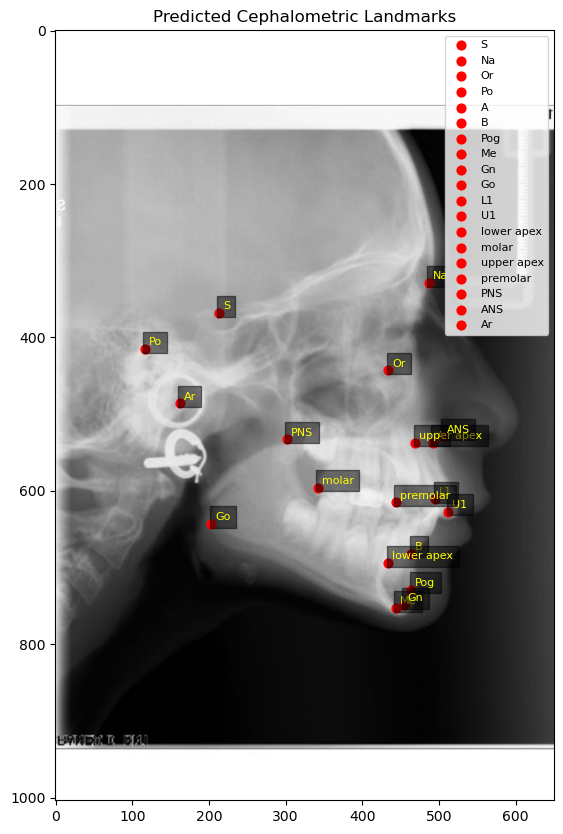

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

LANDMARK_NAMES = {
    1: "S",    # Sella
    2: "Na",   # Nasion
    3: "Or",   # Orbitale
    4: "Po",   # Porion
    5: "A", # A point
    6: "B",    # B point
    7: "Pog",  # Pogonion
    8: "Me",   # Menton
    9: "Gn", # Gn point
    10: "Go",  # Gonion
    11: "L1", # L1 point
    12: "U1", # U1 point
    13: "lower apex",  # lower apex 
    14: "molar",  # molar point
    15: "upper apex",  # upper apex
    16: "premolar", # premolar point
    17: "PNS", # Posterior Nasal Spine
    18: "ANS",   # ANS point
    19: "Ar"   # Articulare
}

# Reading the sample image from the path
image_path = "new1200/ceph400/ceph400/400.1.10.2.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Checking if the image is loaded correctly
if image is None:
    raise ValueError("Image not found. Please check the path.")

def extract_landmark_positions(prediction, threshold=0.1):
    landmark_positions = {}
    for i, (_, landmark_name) in enumerate(LANDMARK_NAMES.items()):
        if landmark_name != "null":
            heatmap = prediction[:, :, i]
            
            # Checking the maximum heatmap value
            max_value = np.max(heatmap)
            print(f"Landmark {landmark_name}: max heatmap value = {max_value}")

            y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
            
            if max_value > threshold:
                landmark_positions[landmark_name] = (x, y)
            else:
                print(f"⚠️ Warning: The maximum value for {landmark_name} is below the threshold, point removed.")
    
    return landmark_positions

def predict_landmarks(model, image):
    resized_image = cv2.resize(image, (256, 256))

    # Normalizing the model input
    input_image = resized_image.astype(np.float32) / 255.0  
    input_image = input_image.reshape((1, 256, 256, 1))

    # Model prediction
    prediction = model.predict(input_image)[0]

    # Checking the model output
    print(f"🔍 Model output shape: {prediction.shape}")

    # Extracting landmarks
    landmarks = extract_landmark_positions(prediction, threshold=0.01)

    # Calculating scaling factors
    scale_x = image.shape[1] / 256
    scale_y = image.shape[0] / 256
    print(f"📏 Scale x: {scale_x}, scale y: {scale_y}")

    # Scaling the landmarks to the original image dimensions
    scaled_landmarks = {
        name: (int(x * scale_x), int(y * scale_y))
        for name, (x, y) in landmarks.items()
    }

    return scaled_landmarks

# Getting the predicted landmarks
landmarks = predict_landmarks(unet, image)

# Visualizing the image and landmarks
def visualize_landmarks(image, landmarks):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap="gray")

    for name, (x, y) in landmarks.items():
        plt.scatter(x, y, color="red", s=40, label=name)
        plt.text(x + 5, y - 5, name, color="yellow", fontsize=8, bbox=dict(facecolor='black', alpha=0.5))

    plt.legend(loc="best", fontsize=8)
    plt.title("Predicted Cephalometric Landmarks")
    plt.show()

visualize_landmarks(image, landmarks)


In [21]:
#we save the model
unet.save('Midterm_Model4.h5')

# Preparing a DataFrame to evaluate model errors in landmark detection, used later for improving final predictions through post-processing.



In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

###### first we load the unet model.
epsilon = 1e-7

def dice_coeff(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(K.cast(y_true, dtype='float32'))
    y_pred_f = K.flatten(K.cast(y_pred, dtype='float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)
model_path = "Midterm_Model4.h5"
unet = tf.keras.models.load_model(model_path, custom_objects={"dice_loss": dice_loss, "dice_coeff": dice_coeff})
unet.summary

In [1]:
# 1. Importing Required Libraries
# Load essential libraries for image processing, numerical computations, and data handling.

# 2. Defining Landmark Mapping
# Map original anatomical landmark names to corresponding predicted landmark names.

# 3. Defining Function to Extract Landmark Positions from Heatmaps
# Extract the coordinates of maximum activation from each heatmap channel.

# 4. Defining Landmark Prediction Function
# Predict landmark positions using the trained model and rescale them to the original image size.

# 5. Loading Landmark Data from CSV Files
# Read ground truth landmark coordinates from multiple CSV files.

# 6. Initializing Results Storage List
# Prepare a list to store prediction errors and correction vectors for each image.

# 7. Iterating Over Data and Images
# Loop through each image and corresponding ground truth landmark coordinates.

# 8. Extracting Ground Truth Landmarks
# Extract true landmark positions from the CSV and store them as coordinate pairs.

# 9. Predicting Landmarks Using the Model
# Predict landmarks on each image using the deep learning model.

# 10. Calculating Normalization Factor (S–Na Distance)
# Compute the Euclidean distance between points S and Na for coordinate normalization.

# 11. Normalizing Coordinates and Calculating Errors
# Normalize both ground truth and predicted coordinates by dividing by S–Na distance.
# Compute error vectors:
# Δx = x_true - x_pred (normalized)
# Δy = y_true - y_pred (normalized)
# Distance error = √(Δx² + Δy²)

# 12. Storing Results for Each Landmark
# Store all computed values (true & predicted coordinates, deltas, distance error) in the results list.

# 13. Creating Final DataFrame for Post-Processing
# Compile the results into a structured DataFrame to be used for downstream error analysis or model correction.


In [5]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random  # For generating random zoom coefficients

# Mapping between the original point names and predicted point names
landmark_mapping = {
    'point_1': 'S', 'point_2': 'Na', 'point_3': 'Or', 'point_4': 'Po',
    'point_5': 'A', 'point_6': 'B', 'point_7': 'Pog', 'point_8': 'Me',
    'point_9': 'Gn', 'point_10': 'Go', 'point_11': 'L1', 'point_12': 'U1',
    'point_13': 'lower apex', 'point_14': 'molar', 'point_15': 'upper apex',
    'point_16': 'premolar', 'point_17': 'PNS', 'point_18': 'ANS', 'point_19': 'Ar'
}

def extract_landmark_positions(prediction, threshold):
    landmark_positions = {}
    for i, (_, landmark_name) in enumerate(LANDMARK_NAMES.items()):
        if landmark_name != "null":
            heatmap = prediction[:, :, i]
            y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
            if np.max(heatmap) > threshold:
                landmark_positions[landmark_name] = (x, y)
    return landmark_positions

def predict_landmarks(model, image):
    resized_image = cv2.resize(image, (256, 256)).astype(np.float32) / 255.0  
    input_image = resized_image.reshape((1, 256, 256, 1))
    prediction = model.predict(input_image)[0]
    landmarks = extract_landmark_positions(prediction, threshold=0.01)
    scale_x = image.shape[1] / 256
    scale_y = image.shape[0] / 256
    sn_length = image.shape[1] / 60  # Calculate 1/10 of the SN length
    return {name: (int(x * scale_x) + int(sn_length), int(y * scale_y) + int(sn_length)) for name, (x, y) in landmarks.items()}

# Paths to the CSV files containing the landmarks
csv_files = ['new1200/test1_senior.csv','new1200/test2_senior.csv','new1200/train_senior.csv']
# Load the landmarks data
landmarks_data = [pd.read_csv(file, delimiter=',', dtype={col: float for col in range(1, 38)}) for file in csv_files]

# Define list to store results
results = []

for df in landmarks_data:
    for i in range(len(df)):
        img_landmarks = list(df.values[i])
        image_path = f"new1200/ceph400/ceph400/{img_landmarks[0]}"
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue
        
        # Extract ground truth landmarks
        true_points = {}
        for landmark_idx in range(1, 20):  # 18 assumed points
            x_idx = 2 * landmark_idx - 1
            y_idx = 2 * landmark_idx
            true_points[f'point_{landmark_idx}'] = (int(img_landmarks[x_idx]), int(img_landmarks[y_idx]))
        
        # Predict landmarks using the model (assumed this function uses the model to predict)
        pred_landmarks = predict_landmarks(unet, image)
        
        # Calculate the S to Na distance for normalization
        x_s, y_s = true_points['point_1']  # Point S
        x_na, y_na = true_points['point_2']  # Point Na
        sn_distance = np.sqrt((x_na - x_s) ** 2 + (y_na - y_s) ** 2)  # Calculate the S to Na distance
        
        # Store the data in a suitable DataFrame for learning
        for true_name, pred_name in landmark_mapping.items():
            if pred_name in pred_landmarks:  # Check if the predicted point exists
                x_true, y_true = true_points[true_name]
                x_pred, y_pred = pred_landmarks[pred_name]

                # Normalize coordinates
                norm_x_true = (x_true / sn_distance)
                norm_y_true = (y_true / sn_distance)
                norm_x_pred = (x_pred / sn_distance)
                norm_y_pred = (y_pred / sn_distance)

                # Correction vector
                delta_x = norm_x_true - norm_x_pred
                delta_y = norm_y_true - norm_y_pred

                # Distance error
                distance_error = np.sqrt(delta_x ** 2 + delta_y ** 2)

                # Store in the results list
                results.append({
                    'image': img_landmarks[0],
                    'point': true_name,
                    'x_pred': norm_x_pred,
                    'y_pred': norm_y_pred,
                    'x_true': norm_x_true,
                    'y_true': norm_y_true,
                    'Δx': delta_x,
                    'Δy': delta_y,
                    'distance_error': distance_error
                })

# Create a DataFrame from the results
correction_df = pd.DataFrame(results)
correction_df


,image,point,x_pred,y_pred,x_true,y_true,Δx,Δy,distance_error
0,98.54.12.1.jpg,point_1,0.516652,0.951431,0.494066,0.934491,-0.022586,-0.016939,0.028232
1,98.54.12.1.jpg,point_2,1.516078,0.889320,1.493492,0.900613,-0.022586,0.011293,0.025252
2,98.54.12.1.jpg,point_3,1.298689,1.295866,1.261987,1.304336,-0.036702,0.008470,0.037667
3,98.54.12.1.jpg,point_4,0.214566,1.261987,0.191980,1.253517,-0.022586,-0.008470,0.024122
4,98.54.12.1.jpg,point_5,1.453967,1.668533,1.434204,1.654417,-0.019763,-0.014116,0.024286
...,...,...,...,...,...,...,...,...,...
21330,98.99.15.1.jpg,point_15,1.387903,1.779143,1.359345,1.776288,-0.028558,-0.002856,0.028700
21331,98.99.15.1.jpg,point_16,1.270817,2.056153,1.256538,2.050441,-0.014279,-0.005712,0.015379
21332,98.99.15.1.jpg,point_17,0.819605,1.659201,0.799615,1.664913,-0.019990,0.005712,0.020790
21333,98.99.15.1.jpg,point_18,1.533547,1.670624,1.553538,1.664913,0.019990,-0.005712,0.020790


# SPEED test

In [3]:
import cv2
import time  # for measuring time

# Path to the CSV files containing landmark points
csv_files = ['new1200/test1_senior.csv']

# Loading the landmark data
landmarks_data = [pd.read_csv(file, delimiter=',', dtype={col: float for col in range(1, 38)}) for file in csv_files]

# List to store processing times for each image
time_taken = []

# Speed test process
for df in landmarks_data:
    for i in range(len(df)):
        img_landmarks = list(df.values[i])
        image_path = f"new1200/ceph400/ceph400/{img_landmarks[0]}"
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue
        
        start_time = time.time()  # Start timing
        
        # Predicting landmarks with the model
        pred_landmarks = predict_landmarks(unet, image)
        
        # Store processing time
        time_taken.append(time.time() - start_time)

# Calculate the average and standard deviation of the times
avg_time = np.mean(time_taken)
std_time = np.std(time_taken)

# Display average and standard deviation results
print(f"Average processing time: {avg_time:.4f} seconds")
print(f"Standard deviation of processing time: {std_time:.4f} seconds")


Average processing time: 0.4539 seconds
Standard deviation of processing time: 0.0491 seconds


# final predictions using post processing adjustments

In [2]:
# 1. Importing Required Libraries
# Load necessary libraries for deep learning (TensorFlow), image processing (OpenCV), numerical operations (NumPy), plotting (Matplotlib), and data manipulation (Pandas).

# 2. Defining Landmark Names
# Create a dictionary mapping index numbers to anatomical landmark names.

# 3. Defining Function to Extract Landmark Positions from Heatmaps
# From the predicted heatmap, find the pixel location with the highest intensity for each landmark and return its coordinates if it exceeds the threshold.

# 4. Defining Function to Predict Landmarks from Model
# Resize and normalize the input image, perform model prediction, extract landmark coordinates, rescale them to the original image size, and apply a positional offset using SN distance.

# 5. Visualizing Predicted Landmarks on Image
# Plot the input image and overlay the predicted landmark positions and names using red dots and blue text.

# 6. Loading Correction Data from CSV File
# Read a CSV file containing average error corrections (delta x, delta y, and distance error) for each point based on prior evaluations.

# 7. Calculating Mean Error for Each Landmark
# Group the correction data by point and calculate average delta_x, delta_y, and distance error for adjustment purposes.

# 8. Extracting Landmark Adjustments
# Filter correction data to keep only relevant landmark points used for model adjustment.

# 9. Adjusting Landmarks Using Correction Data
# Modify the predicted landmark coordinates based on pre-calculated mean delta values, normalized by SN distance between points S and Na.

# 10. Updating Prediction Function to Include Adjustments
# Enhance the `predict_landmarks` function to apply correction offsets after extracting raw model predictions.

# 11. Visualizing Adjusted Landmark Positions
# Display the adjusted landmark positions on the original image using scatter plot and text annotations.

# 12. Reading and Predicting Landmarks on New Image
# Load a new grayscale image, predict its landmarks using the trained model, apply corrections, and visualize the final output.

# 13. Error Calculation Explanation:
# Error for each point is calculated using the formula:
# Δx = x_true - x_pred (normalized by SN distance)
# Δy = y_true - y_pred (normalized by SN distance)
# Distance Error = √(Δx² + Δy²)
# These metrics help evaluate model accuracy and correct systematic deviations.


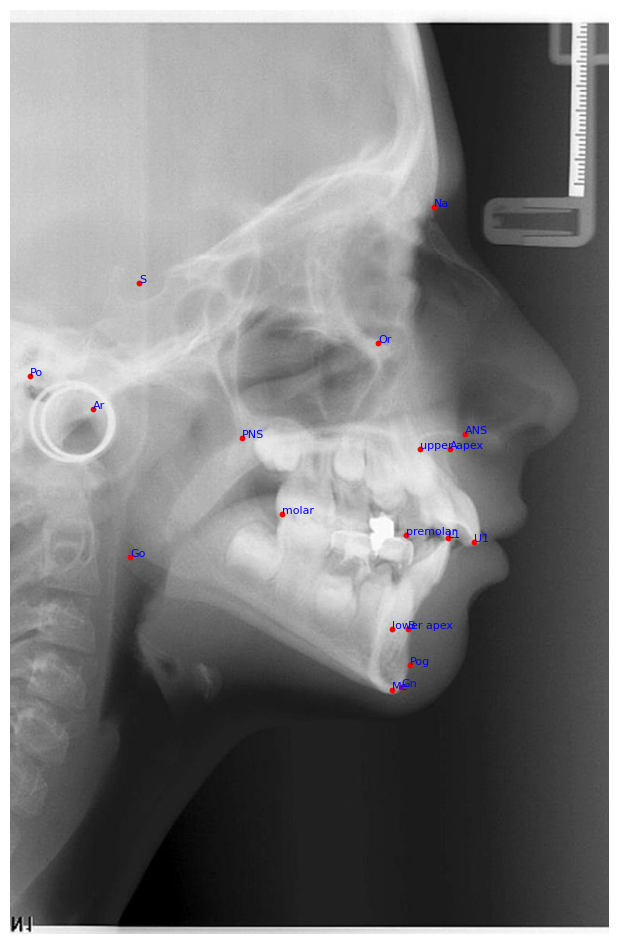

In [9]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import pandas as pd

LANDMARK_NAMES = {
    1: "S",    # Sella
    2: "Na",   # Nasion
    3: "Or",   # Orbitale
    4: "Po",   # Porion
    5: "A",    # A point
    6: "B",    # B point
    7: "Pog",  # Pogonion
    8: "Me",   # Menton
    9: "Gn",   # Gn point
    10: "Go",  # Gonion
    11: "L1",  # L1 point
    12: "U1",  # U1 point
    13: "lower apex",  # lower apex
    14: "molar",  # molar point
    15: "upper apex",  # upper apex
    16: "premolar",  # premolar point
    17: "PNS",  # Posterior Nasal Spine
    18: "ANS",  # ANS point
    19: "Ar"    # Articulare
}


def extract_landmark_positions(prediction, threshold):
    landmark_positions = {}
    for i, (_, landmark_name) in enumerate(LANDMARK_NAMES.items()):
        if landmark_name != "null":
            heatmap = prediction[:, :, i]
            y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
            if np.max(heatmap) > threshold:
                landmark_positions[landmark_name] = (x, y)
    return landmark_positions

def predict_landmarks(model, image):
    resized_image = cv2.resize(image, (256, 256)).astype(np.float32) / 255.0  
    input_image = resized_image.reshape((1, 256, 256, 1))
    prediction = model.predict(input_image)[0]
    landmarks = extract_landmark_positions(prediction, threshold=0.01)
    scale_x = image.shape[1] / 256
    scale_y = image.shape[0] / 256
    sn_length = image.shape[1] / 60  # Calculating 1/10th of the SN length
    return {name: (int(x * scale_x) + int(sn_length), int(y * scale_y) + int(sn_length)) for name, (x, y) in landmarks.items()}


def visualize_landmarks(image, landmarks):
    # Adjust image size
    plt.figure(figsize=(12, 12))  # Increase display size
    plt.imshow(image, cmap="gray")
    for name, (x, y) in landmarks.items():
        plt.scatter(x, y, color="red", s=10)
        plt.text(x, y, f"{name}", color="blue", fontsize=8)  # Display landmark names
    plt.axis("off")
    plt.show()


# Load data from CSV file
correction_df = pd.read_csv("landmark_correction_data.csv")

# Calculate mean error for each point
mean_errors = correction_df.groupby('point').agg(
    mean_delta_x=('Δx', 'mean'),
    mean_delta_y=('Δy', 'mean'),
    mean_distance_error=('distance_error', 'mean')
).reset_index()

# Extract data for the desired points
landmark_adjustments = mean_errors[mean_errors['point'].isin([
    'point_1', 'point_2', 'point_3', 'point_4', 'point_5', 'point_6', 'point_7', 'point_8', 'point_9',
    'point_10', 'point_11', 'point_12', 'point_13', 'point_14', 'point_15', 'point_16', 'point_17', 'point_18'
])]


# Adjust landmarks based on correction data
def adjust_landmarks(landmarks, adjustments):
    adjusted_landmarks = {}

    # Calculate SN distance based on predicted points
    if 'S' in landmarks and 'Na' in landmarks:
        x_s, y_s = landmarks['S']
        x_na, y_na = landmarks['Na']
        sn_distance = np.sqrt((x_na - x_s) ** 2 + (y_na - y_s) ** 2)
    else:
        sn_distance = 1  # Default value if points are not found

    for point, (x, y) in landmarks.items():
        if point in adjustments['point'].values:
            delta_x = adjustments.loc[adjustments['point'] == point, 'mean_delta_x'].values[0] * sn_distance
            delta_y = adjustments.loc[adjustments['point'] == point, 'mean_delta_y'].values[0] * sn_distance
            adjusted_landmarks[point] = (x + delta_x, y + delta_y)
        else:
            adjusted_landmarks[point] = (x, y)

    return adjusted_landmarks


def extract_landmark_positions(prediction, threshold):
    landmark_positions = {}
    for i, (_, landmark_name) in enumerate(LANDMARK_NAMES.items()):
        if landmark_name != "null":
            heatmap = prediction[:, :, i]
            y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
            if np.max(heatmap) > threshold:
                landmark_positions[landmark_name] = (x, y)
    return landmark_positions

def predict_landmarks(model, image):
    resized_image = cv2.resize(image, (256, 256)).astype(np.float32) / 255.0  
    input_image = resized_image.reshape((1, 256, 256, 1))
    prediction = model.predict(input_image)[0]
    landmarks = extract_landmark_positions(prediction, threshold=0.01)  # Reducing the threshold
    scale_x = image.shape[1] / 256
    scale_y = image.shape[0] / 256
    sn_length = image.shape[1] / 100  # Calculating 1/10th of the SN length
    landmarks = {name: (int(x * scale_x) + int(sn_length), int(y * scale_y) + int(sn_length)) for name, (x, y) in landmarks.items()}
    landmarks = adjust_landmarks(landmarks, landmark_adjustments)  # Apply adjustments
    return landmarks

def visualize_landmarks(image, landmarks):
    # Adjust image size
    plt.figure(figsize=(12, 12))  # Increase display size
    plt.imshow(image, cmap="gray")
    for name, (x, y) in landmarks.items():
        plt.scatter(x, y, color="red", s=10)
        plt.text(x, y, f"{name}", color="blue", fontsize=8)  # Display landmark names
    plt.axis("off")
    plt.show()

# Read image and predict landmarks
image_path = "New_test.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Please check the path.")

landmarks = predict_landmarks(unet, image)
visualize_landmarks(image, landmarks)


In [8]:
for name, coords in landmarks.items():
     print(f"{name}={coords}")


S=(213, 368)
Na=(487, 329)
Or=(434, 443)
Po=(116, 415)
A=(492, 537)
B=(464, 682)
Pog=(464, 729)
Me=(444, 753)
Gn=(454, 749)
Go=(203, 643)
L1=(495, 611)
U1=(512, 627)
lower apex=(434, 694)
molar=(342, 596)
upper apex=(469, 537)
premolar=(444, 615)
PNS=(302, 533)
ANS=(505, 529)
Ar=(162, 486)
